<a href="https://colab.research.google.com/github/nicholasrichers/Adv_Fin_ML_Exercises/blob/master/Carteira_Otima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto cateira Otima

Autor: Nicholas Richers

Repo: https://github.com/nicholasrichers/cateira_otima

## Carregando os dados

In [16]:
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import numpy as np
import sys

In [3]:
url = 'https://raw.githubusercontent.com/nicholasrichers/cateira_otima/main/Codigo_Acoes_IBOV.csv'
ibov_tickers = pd.read_csv(url)

In [4]:
ibov_tickers.drop(71, inplace=True) #DROP VIVT4.SA (VIVO) Nao encontrada
ibov_tickers

,Codigo
0,ABEV3.SA
1,AZUL4.SA
2,B3SA3.SA
3,BBAS3.SA
4,BBDC3.SA
...,...
69,USIM5.SA
70,VALE3.SA
72,VVAR3.SA
73,WEGE3.SA


In [ ]:
%%time
bvmf_data = pd.DataFrame()
for t in ibov_tickers['Codigo']:
    print(t)
    bvmf_data[t] = web.DataReader(t, data_source='yahoo', start='2016-1-1', end='2020-12-31')['Close']

8 ações não possuem histórico em todo o intervalo

In [23]:
bvmf_data.dropna(axis=1, inplace=True)
bvmf_data.shape

(1242, 65)

In [7]:
bvmf_data.head()

,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BTOW3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENGI11.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,HGTX3.SA,HYPE3.SA,IGTA3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LAME4.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,17.209999,3.483333,14.24,10.452175,10.814379,22.830000,12.291185,4.70,54.220001,27.10,7.270903,13.987370,12.15,22.368055,4.726493,9.42,14.437953,6.000,3.86,12.53,7.28,4.77,26.128000,5.427937,9.90,29.320000,11.112228,13.957694,6.600,7.625,4.54,1.60,2.41,9.48333,21.090000,18.270000,5.41869,15.2303,12.05,21.940001,15.5883,13.3471,0.070117,6.23,7.57282,12.5300,55.299999,8.67,6.87,13.75,7.032,5.99,7.05971,14.65,18.150000,14.6266,20.01,16.15,10.2106,28.750000,1.46,12.69,1.20,11.2615,13.90
2016-01-05,17.480000,3.616666,14.29,10.524616,10.842838,24.290001,12.723834,4.75,55.250000,25.93,7.257525,14.190085,12.46,23.437500,4.592882,9.20,14.633061,6.030,3.67,12.52,7.61,4.70,26.440001,5.547891,9.99,29.320000,11.693969,13.957694,6.920,7.715,4.33,1.47,2.25,9.48333,21.340000,18.340000,5.50900,15.3576,11.45,21.879999,15.6713,14.2975,0.070820,5.95,7.71827,12.7333,55.299999,8.45,6.68,14.12,7.360,5.69,7.23507,14.43,18.350000,14.8826,20.01,15.90,10.1607,29.410000,1.34,12.52,1.25,11.8077,12.46
2016-01-06,17.309999,3.613333,14.29,10.338340,10.689160,24.100000,12.537008,4.42,54.150002,27.75,7.177257,14.267310,12.29,23.798611,4.359062,9.37,14.486730,5.915,3.38,12.16,7.32,4.80,26.048000,5.447929,10.14,28.900000,11.772849,13.957694,6.960,7.675,3.98,1.28,2.00,9.48333,21.459999,18.590000,5.55826,15.2970,10.40,21.940001,15.5302,14.2149,0.064687,5.92,7.53645,12.7333,55.299999,8.06,6.40,14.05,7.428,5.22,7.30159,14.10,17.750000,14.8106,20.01,15.95,10.4135,29.200001,1.22,11.60,1.25,11.5385,13.52
2016-01-07,16.850000,3.463333,13.95,10.007181,10.472872,23.150000,11.907700,4.14,52.020000,27.00,7.150501,13.813614,11.55,23.888887,4.116892,9.27,13.901408,5.850,3.30,12.11,7.36,4.54,25.440001,5.178032,9.90,28.270000,11.043208,13.957694,6.768,7.685,3.80,1.20,1.87,9.48333,21.110001,18.280001,5.47616,15.0061,11.00,21.150000,15.1481,13.9835,0.056093,5.67,7.50009,12.4000,55.299999,7.83,6.26,13.75,7.524,4.55,7.25624,13.71,16.620001,14.1385,20.01,15.42,10.1407,28.025000,1.15,10.91,1.18,11.2077,13.45
2016-01-08,17.070000,3.506666,13.95,9.986484,10.267968,23.590000,11.750372,4.09,53.020000,27.07,7.210702,14.180432,11.50,24.305555,3.924826,8.75,13.862386,5.850,3.42,12.15,7.50,4.32,25.080000,5.038085,9.58,28.370001,11.437608,13.957694,6.860,7.715,3.93,1.25,1.79,9.48333,21.100000,18.549999,5.47616,15.0121,11.20,20.780001,15.2478,13.9504,0.056328,5.90,7.50918,12.4833,55.299999,7.86,6.27,13.67,7.464,4.30,7.25624,13.71,16.820000,14.2265,20.01,16.08,10.1640,28.475000,1.18,10.54,1.18,11.1538,12.65


## Log-Returns

In [8]:
# Normalizing returns by using log
log_returns = np.log(bvmf_data / bvmf_data.shift(1))

#Deletando o primeiro valor da serie
log_returns.dropna(axis=0, inplace=True)
log_returns.head()

,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BTOW3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENGI11.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,HGTX3.SA,HYPE3.SA,IGTA3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LAME4.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.015567,0.037563,0.003505,0.006907,0.002628,0.061989,0.034595,0.010582,0.018818,-0.044133,-0.001842,0.014389,0.025194,0.046703,-0.028676,-0.023632,0.013423,0.004988,-0.050475,-0.000798,0.044332,-0.014784,0.011870,0.021859,0.009050,0.000000,0.051027,0.000000,0.047346,0.011734,-0.047359,-0.084741,-0.068697,0.0,0.011784,0.003824,0.016529,0.008324,-0.051075,-0.002739,0.005310,0.068786,0.009976,-0.045985,0.019025,0.016095,0.0,-0.025702,-0.028046,0.026553,0.045589,-0.051381,0.024536,-0.015131,0.010959,0.017351,0.0,-0.015601,-0.004899,0.022697,-0.085767,-0.013487,0.040822,0.047362,-0.109365
2016-01-06,-0.009773,-0.000922,0.000000,-0.017858,-0.014275,-0.007853,-0.014792,-0.072005,-0.020110,0.067835,-0.011122,0.005427,-0.013738,0.015290,-0.052251,0.018310,-0.010050,-0.019256,-0.082316,-0.029176,-0.038853,0.021053,-0.014937,-0.018182,0.014903,-0.014428,0.006723,0.000000,0.005764,-0.005198,-0.084286,-0.138402,-0.117783,0.0,0.005607,0.013539,0.008902,-0.003954,-0.096184,0.002739,-0.009044,-0.005794,-0.090581,-0.005055,-0.023839,0.000000,0.0,-0.047253,-0.042820,-0.004970,0.009197,-0.086213,0.009152,-0.023135,-0.033244,-0.004850,0.0,0.003140,0.024576,-0.007166,-0.093819,-0.076322,0.000000,-0.023063,0.081647
2016-01-07,-0.026934,-0.042399,-0.024080,-0.032556,-0.020442,-0.040217,-0.051500,-0.065444,-0.040130,-0.027399,-0.003735,-0.032316,-0.062100,0.003786,-0.057158,-0.010730,-0.041243,-0.011050,-0.023953,-0.004120,0.005450,-0.055689,-0.023618,-0.050810,-0.023953,-0.022040,-0.063980,0.000000,-0.027974,0.001302,-0.046281,-0.064538,-0.067209,0.0,-0.016444,-0.016816,-0.014881,-0.019200,0.056090,-0.036672,-0.024911,-0.016413,-0.142549,-0.043147,-0.004836,-0.026524,0.0,-0.028951,-0.022118,-0.021584,0.012841,-0.137370,-0.006230,-0.028049,-0.065779,-0.046442,0.0,-0.033793,-0.026546,-0.041072,-0.059089,-0.061325,-0.057629,-0.029088,-0.005191
2016-01-08,0.012972,0.012434,0.000000,-0.002070,-0.019759,0.018828,-0.013300,-0.012151,0.019041,0.002589,0.008384,0.026208,-0.004338,0.017292,-0.047776,-0.057730,-0.002811,0.000000,0.035718,0.003298,0.018843,-0.049672,-0.014252,-0.027399,-0.032857,0.003531,0.035091,0.000000,0.013502,0.003896,0.033638,0.040822,-0.043723,0.0,-0.000474,0.014662,0.000000,0.000400,0.018018,-0.017649,0.006560,-0.002370,0.004181,0.039763,0.001211,0.006695,0.0,0.003824,0.001596,-0.005835,-0.008006,-0.056512,0.000000,0.000000,0.011962,0.006205,0.0,0.041911,0.002295,0.015930,0.025752,-0.034502,0.000000,-0.004821,-0.061322
2016-01-11,-0.015944,-0.001903,-0.029093,-0.019357,-0.028678,-0.031872,0.019064,-0.039906,-0.023665,0.025170,0.006473,-0.043833,-0.011369,-0.048290,0.012685,-0.005731,0.003513,0.001708,-0.014728,0.017136,-0.001334,0.002312,0.001594,-0.007968,-0.038303,-0.003885,0.003442,-0.036368,-0.001751,-0.005850,-0.038915,-0.024293,-0.057487,0.0,-0.005703,0.014982,-0.012066,-0.011773,0.019452,-0.050838,0.005429,-0.028849,0.000000,0.016807,0.017996,0.026092,0.0,-0.036273,-0.029128,0.034511,-0.001341,-0.047628,0.001665,0.002186,0.025244,-0.024485,0.0,0.010517,-0.060030,-0.026692,0.016807,-0.028876,-0.070204,-0.023017,0.027292


## Corr & Cov Matrix

In [74]:
import seaborn as sns
from string import ascii_letters
from scipy import stats

def plot_corr_matrix_full(df):

    # Set up the matplotlib figure
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(12, 12) )


    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    ax.set_title('Spearman Corr Matrix', fontsize=18)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df.corr(method="pearson"),  cmap=cmap, vmax=.8, center=0.4, 
                square=True, linewidths=.75, cbar_kws={"shrink": .8},  annot=False)


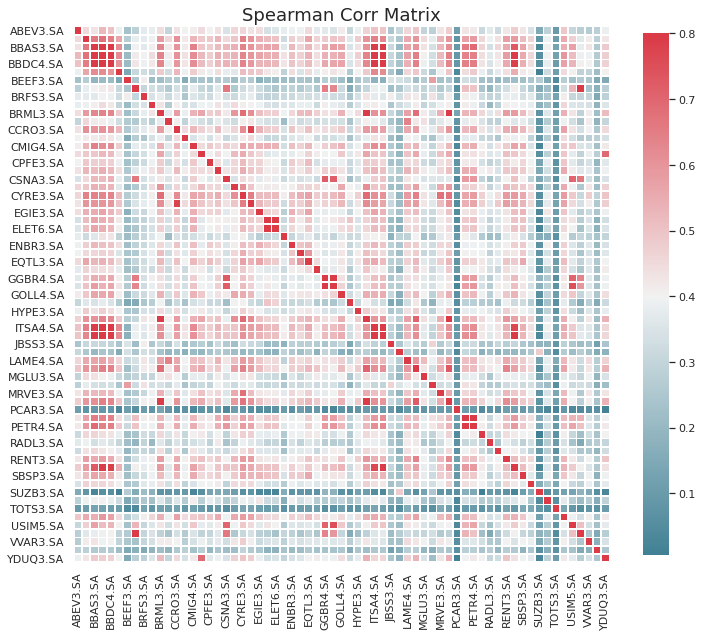

In [9]:
plot_corr_matrix_full(log_returns)

In [10]:
log_returns.cov()

,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BTOW3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENGI11.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,HGTX3.SA,HYPE3.SA,IGTA3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LAME4.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.000332,0.000202,0.000235,0.000229,0.000225,0.000144,0.000109,0.000158,0.000186,0.000230,0.000217,0.000206,0.000220,0.000217,0.000232,0.000275,0.000130,0.000195,0.000255,0.000317,0.000261,0.000232,0.000130,0.000240,0.000219,0.000205,0.000137,0.000144,0.000146,0.000146,0.000216,0.000230,0.000400,0.000213,0.000150,0.000203,0.000188,0.000192,0.000155,0.000116,0.000224,0.000226,0.000209,0.000154,0.000217,0.000213,0.000079,0.000258,0.000256,0.000177,0.000133,0.000201,0.000222,0.000212,0.000199,0.000154,0.000066,0.000083,0.000197,0.000243,0.000225,0.000156,0.000215,0.000211,0.000241
B3SA3.SA,0.000202,0.000597,0.000479,0.000395,0.000388,0.000283,0.000173,0.000286,0.000248,0.000318,0.000385,0.000422,0.000412,0.000308,0.000400,0.000404,0.000212,0.000318,0.000443,0.000459,0.000492,0.000432,0.000212,0.000495,0.000418,0.000232,0.000223,0.000220,0.000245,0.000246,0.000384,0.000440,0.000638,0.000337,0.000250,0.000351,0.000326,0.000327,0.000264,0.000127,0.000365,0.000368,0.000431,0.000275,0.000362,0.000355,0.000074,0.000463,0.000484,0.000348,0.000190,0.000367,0.000408,0.000350,0.000323,0.000278,0.000048,0.000154,0.000292,0.000366,0.000469,0.000274,0.000447,0.000286,0.000355
BBAS3.SA,0.000235,0.000479,0.000890,0.000577,0.000592,0.000379,0.000147,0.000368,0.000298,0.000404,0.000504,0.000468,0.000498,0.000374,0.000594,0.000494,0.000253,0.000381,0.000626,0.000614,0.000598,0.000529,0.000264,0.000661,0.000572,0.000319,0.000301,0.000272,0.000282,0.000289,0.000529,0.000624,0.000889,0.000398,0.000275,0.000431,0.000486,0.000504,0.000325,0.000125,0.000456,0.000451,0.000507,0.000304,0.000434,0.000446,0.000105,0.000642,0.000689,0.000426,0.000197,0.000473,0.000480,0.000523,0.000435,0.000335,0.000019,0.000193,0.000428,0.000440,0.000698,0.000348,0.000563,0.000319,0.000492
BBDC3.SA,0.000229,0.000395,0.000577,0.000573,0.000548,0.000302,0.000129,0.000306,0.000261,0.000354,0.000411,0.000370,0.000402,0.000314,0.000455,0.000424,0.000204,0.000320,0.000499,0.000487,0.000471,0.000422,0.000219,0.000513,0.000443,0.000309,0.000234,0.000224,0.000229,0.000230,0.000417,0.000462,0.000709,0.000347,0.000242,0.000363,0.000420,0.000441,0.000256,0.000118,0.000366,0.000389,0.000376,0.000238,0.000350,0.000378,0.000082,0.000504,0.000515,0.000329,0.000174,0.000353,0.000401,0.000458,0.000341,0.000267,0.000035,0.000154,0.000323,0.000386,0.000498,0.000288,0.000417,0.000262,0.000388
BBDC4.SA,0.000225,0.000388,0.000592,0.000548,0.000597,0.000300,0.000133,0.000319,0.000262,0.000343,0.000416,0.000359,0.000402,0.000313,0.000465,0.000426,0.000205,0.000316,0.000527,0.000491,0.000487,0.000427,0.000208,0.000509,0.000435,0.000309,0.000236,0.000226,0.000226,0.000231,0.000443,0.000495,0.000738,0.000327,0.000229,0.000365,0.000429,0.000460,0.000251,0.000118,0.000354,0.000394,0.000369,0.000244,0.000351,0.000379,0.000081,0.000519,0.000531,0.000327,0.000171,0.000344,0.000391,0.000466,0.000340,0.000266,0.000037,0.000149,0.000292,0.000381,0.000528,0.000304,0.000431,0.000259,0.000391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USIM5.SA,0.000225,0.000469,0.000698,0.000498,0.000528,0.000336,0.000244,0.000657,0.000337,0.000476,0.000467,0.000505,0.000486,0.000402,0.000617,0.000512,0.000266,0.000413,0.00

## Carteira Otima

In [66]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
  dataset = dataset.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos

  else:  
    pesos = np.random.random(len(dataset.columns))
    pesos = pesos / pesos.sum()


  for i in dataset.columns:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total
  

  dataset['soma_carteira'] = dataset.sum(axis = 1)
  dataset['taxa_retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa_retorno'][i] = ((dataset['soma_carteira'][i] / dataset['soma_carteira'][i - 1]) - 1) * 100

  acoes_pesos = pd.DataFrame(data = {'acoes': dataset.columns[0:-2], 'pesos(%)': pesos * 100})

  return dataset, dataset.index, acoes_pesos, dataset['soma_carteira'].tail(1)

In [46]:
taxa_selic_historico = np.array([14.25, 12.25, 6.5, 5.0, 2.0]) #2016..2020

dinheiro_total = 15000
sem_risco = taxa_selic_historico.mean() / 100
bvmf_data.head()

,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BTOW3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENGI11.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,HGTX3.SA,HYPE3.SA,IGTA3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LAME4.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,17.209999,3.483333,14.24,10.452175,10.814379,22.830000,12.291185,4.70,54.220001,27.10,7.270903,13.987370,12.15,22.368055,4.726493,9.42,14.437953,6.000,3.86,12.53,7.28,4.77,26.128000,5.427937,9.90,29.320000,11.112228,13.957694,6.600,7.625,4.54,1.60,2.41,9.48333,21.090000,18.270000,5.41869,15.2303,12.05,21.940001,15.5883,13.3471,0.070117,6.23,7.57282,12.5300,55.299999,8.67,6.87,13.75,7.032,5.99,7.05971,14.65,18.150000,14.6266,20.01,16.15,10.2106,28.750000,1.46,12.69,1.20,11.2615,13.90
2016-01-05,17.480000,3.616666,14.29,10.524616,10.842838,24.290001,12.723834,4.75,55.250000,25.93,7.257525,14.190085,12.46,23.437500,4.592882,9.20,14.633061,6.030,3.67,12.52,7.61,4.70,26.440001,5.547891,9.99,29.320000,11.693969,13.957694,6.920,7.715,4.33,1.47,2.25,9.48333,21.340000,18.340000,5.50900,15.3576,11.45,21.879999,15.6713,14.2975,0.070820,5.95,7.71827,12.7333,55.299999,8.45,6.68,14.12,7.360,5.69,7.23507,14.43,18.350000,14.8826,20.01,15.90,10.1607,29.410000,1.34,12.52,1.25,11.8077,12.46
2016-01-06,17.309999,3.613333,14.29,10.338340,10.689160,24.100000,12.537008,4.42,54.150002,27.75,7.177257,14.267310,12.29,23.798611,4.359062,9.37,14.486730,5.915,3.38,12.16,7.32,4.80,26.048000,5.447929,10.14,28.900000,11.772849,13.957694,6.960,7.675,3.98,1.28,2.00,9.48333,21.459999,18.590000,5.55826,15.2970,10.40,21.940001,15.5302,14.2149,0.064687,5.92,7.53645,12.7333,55.299999,8.06,6.40,14.05,7.428,5.22,7.30159,14.10,17.750000,14.8106,20.01,15.95,10.4135,29.200001,1.22,11.60,1.25,11.5385,13.52
2016-01-07,16.850000,3.463333,13.95,10.007181,10.472872,23.150000,11.907700,4.14,52.020000,27.00,7.150501,13.813614,11.55,23.888887,4.116892,9.27,13.901408,5.850,3.30,12.11,7.36,4.54,25.440001,5.178032,9.90,28.270000,11.043208,13.957694,6.768,7.685,3.80,1.20,1.87,9.48333,21.110001,18.280001,5.47616,15.0061,11.00,21.150000,15.1481,13.9835,0.056093,5.67,7.50009,12.4000,55.299999,7.83,6.26,13.75,7.524,4.55,7.25624,13.71,16.620001,14.1385,20.01,15.42,10.1407,28.025000,1.15,10.91,1.18,11.2077,13.45
2016-01-08,17.070000,3.506666,13.95,9.986484,10.267968,23.590000,11.750372,4.09,53.020000,27.07,7.210702,14.180432,11.50,24.305555,3.924826,8.75,13.862386,5.850,3.42,12.15,7.50,4.32,25.080000,5.038085,9.58,28.370001,11.437608,13.957694,6.860,7.715,3.93,1.25,1.79,9.48333,21.100000,18.549999,5.47616,15.0121,11.20,20.780001,15.2478,13.9504,0.056328,5.90,7.50918,12.4833,55.299999,7.86,6.27,13.67,7.464,4.30,7.25624,13.71,16.820000,14.2265,20.01,16.08,10.1640,28.475000,1.18,10.54,1.18,11.1538,12.65


### Modelo aleatório

In [43]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0
  
  #loop tentativas aleatorias
  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns))
    pesos = pesos / pesos.sum()

    #normalizando a série (1, 1.01, 1.003, ...)
    for i in dataset.columns[:]:
      dataset[i] = dataset[i] / dataset[i][0]

    #atribuindo os pesos
    for i, acao in enumerate(dataset.columns[:]):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    #log-returns e matriz cov
    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    #colunas aux
    dataset['soma_carteira'] = dataset.sum(axis = 1)
    dataset['taxa_retorno'] = 0.0

    #pula 1a linha NaN (.shift(1))
    for i in range(1, len(dataset)):
      dataset['taxa_retorno'][i] = np.log(dataset['soma_carteira'][i] / dataset['soma_carteira'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(250)
    retorno_esperado = np.sum(dataset['taxa_retorno'].mean() * pesos) * 250 #n_dias_ano
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 250, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)
    
    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [61]:
%%time
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(bvmf_data, 15000, sem_risco, 1000)

CPU times: user 2min 48s, sys: 1.61 s, total: 2min 50s
Wall time: 2min 48s


melhor sharpe:  1.6883501986078546


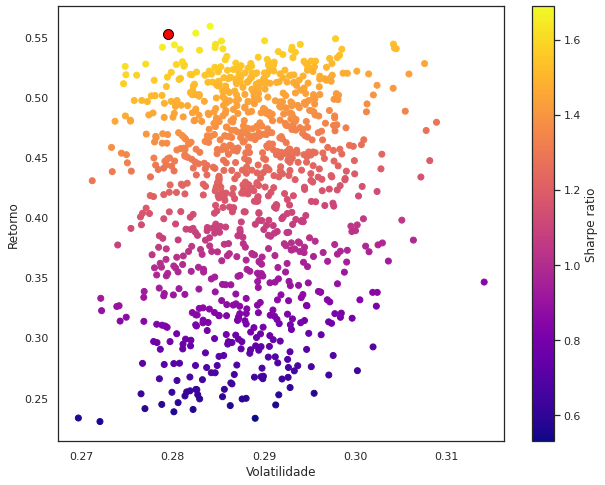

In [77]:
print('melhor sharpe: ', sharpe_ratio)
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio, cmap='plasma')
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100, edgecolors='black');

In [68]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(bvmf_data, 15000, melhores_pesos=melhores_pesos)

In [76]:
print('valor da carteira: ', soma_valor)
acoes_pesos.sort_values('pesos(%)', ascending=False)

valor da carteira:  Date
2020-12-30    232709.165934
Name: soma_carteira, dtype: float64


,acoes,pesos(%)
36,ITSA4.SA,3.487453
42,MGLU3.SA,3.453254
5,BBSE3.SA,3.430183
47,PETR3.SA,3.313087
63,WEGE3.SA,3.281585
...,...,...
14,CMIG4.SA,0.156832
13,CIEL3.SA,0.156003
32,GOLL4.SA,0.151357
35,IGTA3.SA,0.085993




---



---



### Modelo Otimizado

In [78]:
!pip install mlrose

In [81]:
import mlrose

In [82]:
dinheiro_total = 15000
sem_risco = taxa_selic_historico.mean() / 100

In [ ]:
np.random.seed(10)
pesos = np.random.random(len(bvmf_data.columns) - 0)
pesos = pesos / pesos.sum()
pesos

In [105]:
def visualiza_alocacao(solucao):
  colunas = bvmf_data.columns[:]
  for i in range(len(solucao)):
    print(colunas[i], solucao[i] * 100)

In [98]:
def fitness_function(solucao):
  dataset = bvmf_data.copy()
  pesos = solucao / solucao.sum()

  for i in dataset.columns[:]:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[:]):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  #log-returns e matriz cov
  retorno_carteira = np.log(dataset / dataset.shift(1))
  matriz_covariancia = retorno_carteira.cov()

  dataset['soma_carteira'] = dataset.sum(axis = 1)
  dataset['taxa_retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa_retorno'][i] = np.log(dataset['soma_carteira'][i] / dataset['soma_carteira'][i - 1])

  #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(250)
  retorno_esperado = np.sum(dataset['taxa_retorno'].mean() * pesos) * 250 #n_dias_ano
  volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 250, pesos)))
  sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

  return sharpe_ratio

In [101]:
sharpe_inicial = fitness_function(pesos)
print('sharpe carteira inicial: ', sharpe_inicial)

sharpe carteira inicial:  0.9531061291664258


In [102]:
sharpe_otimo_aleatorio = fitness_function(melhores_pesos)
print('sharpe otimo aleatório: ', sharpe_otimo_aleatorio)

sharpe otimo aleatório:  1.6883501986078546


Utilizando o ML Rose
https://mlrose.readthedocs.io/en/stable/source/algorithms.html

In [109]:
fitness = mlrose.CustomFitness(fitness_function)

In [120]:
problema_maximizacao = mlrose.ContinuousOpt(length=len(bvmf_data.columns), 
                                            fitness_fn=fitness,
                                            maximize = True, 
                                            min_val = 0, 
                                            max_val = 1)

In [121]:
%%time
melhor_solucao, melhor_custo = mlrose.hill_climb(problema_maximizacao, random_state=1)
melhor_solucao = melhor_solucao / melhor_solucao.sum()
print('sharpe otimo hclimb: ', melhor_custo)
#visualiza_alocacao(melhor_solucao)

sharpe otimo hclimb:  1.0431429557950398


In [126]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(bvmf_data, 15000, melhores_pesos=melhor_solucao)
soma_valor

Date
2020-12-30    101993.653578
Name: soma_carteira, dtype: float64

In [131]:
%%time
melhor_solucao, melhor_custo = mlrose.simulated_annealing(problema_maximizacao, random_state=1)
melhor_solucao = melhor_solucao / melhor_solucao.sum()
print('sharpe otimo SA: ', melhor_custo)
#visualiza_alocacao(melhor_solucao)

sharpe otimo SA:  2.2949751664941673
CPU times: user 5min 46s, sys: 2.25 s, total: 5min 49s
Wall time: 5min 46s


In [132]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(bvmf_data, 15000, melhores_pesos=melhor_solucao)
soma_valor

Date
2020-12-30    351118.896172
Name: soma_carteira, dtype: float64

In [129]:
%%time
melhor_solucao, melhor_custo = mlrose.genetic_alg(problema_maximizacao, random_state=1)
melhor_solucao = melhor_solucao / melhor_solucao.sum()
print('sharpe otimo GA: ', melhor_custo)
#visualiza_alocacao(melhor_solucao)

sharpe otimo SA:  1.7873334730124553
CPU times: user 9min 49s, sys: 3.62 s, total: 9min 52s
Wall time: 9min 49s


In [130]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(bvmf_data, 15000, melhores_pesos=melhor_solucao)
soma_valor

Date
2020-12-30    250023.979453
Name: soma_carteira, dtype: float64

## CAPM

In [136]:
capm_data = bvmf_data.copy()
IBOV = 'BVSP.SA'
capm_data[IBOV] = web.DataReader(f'^BVSP', data_source='yahoo', start='2016-1-1', end='2020-12-31')['Close']
capm_data.head()

,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BTOW3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENGI11.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,HGTX3.SA,HYPE3.SA,IGTA3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LAME4.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA,BVSP.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,17.209999,3.483333,14.24,10.452175,10.814379,22.830000,12.291185,4.70,54.220001,27.10,7.270903,13.987370,12.15,22.368055,4.726493,9.42,14.437953,6.000,3.86,12.53,7.28,4.77,26.128000,5.427937,9.90,29.320000,11.112228,13.957694,6.600,7.625,4.54,1.60,2.41,9.48333,21.090000,18.270000,5.41869,15.2303,12.05,21.940001,15.5883,13.3471,0.070117,6.23,7.57282,12.5300,55.299999,8.67,6.87,13.75,7.032,5.99,7.05971,14.65,18.150000,14.6266,20.01,16.15,10.2106,28.750000,1.46,12.69,1.20,11.2615,13.90,42141.0
2016-01-05,17.480000,3.616666,14.29,10.524616,10.842838,24.290001,12.723834,4.75,55.250000,25.93,7.257525,14.190085,12.46,23.437500,4.592882,9.20,14.633061,6.030,3.67,12.52,7.61,4.70,26.440001,5.547891,9.99,29.320000,11.693969,13.957694,6.920,7.715,4.33,1.47,2.25,9.48333,21.340000,18.340000,5.50900,15.3576,11.45,21.879999,15.6713,14.2975,0.070820,5.95,7.71827,12.7333,55.299999,8.45,6.68,14.12,7.360,5.69,7.23507,14.43,18.350000,14.8826,20.01,15.90,10.1607,29.410000,1.34,12.52,1.25,11.8077,12.46,42419.0
2016-01-06,17.309999,3.613333,14.29,10.338340,10.689160,24.100000,12.537008,4.42,54.150002,27.75,7.177257,14.267310,12.29,23.798611,4.359062,9.37,14.486730,5.915,3.38,12.16,7.32,4.80,26.048000,5.447929,10.14,28.900000,11.772849,13.957694,6.960,7.675,3.98,1.28,2.00,9.48333,21.459999,18.590000,5.55826,15.2970,10.40,21.940001,15.5302,14.2149,0.064687,5.92,7.53645,12.7333,55.299999,8.06,6.40,14.05,7.428,5.22,7.30159,14.10,17.750000,14.8106,20.01,15.95,10.4135,29.200001,1.22,11.60,1.25,11.5385,13.52,41773.0
2016-01-07,16.850000,3.463333,13.95,10.007181,10.472872,23.150000,11.907700,4.14,52.020000,27.00,7.150501,13.813614,11.55,23.888887,4.116892,9.27,13.901408,5.850,3.30,12.11,7.36,4.54,25.440001,5.178032,9.90,28.270000,11.043208,13.957694,6.768,7.685,3.80,1.20,1.87,9.48333,21.110001,18.280001,5.47616,15.0061,11.00,21.150000,15.1481,13.9835,0.056093,5.67,7.50009,12.4000,55.299999,7.83,6.26,13.75,7.524,4.55,7.25624,13.71,16.620001,14.1385,20.01,15.42,10.1407,28.025000,1.15,10.91,1.18,11.2077,13.45,40695.0
2016-01-08,17.070000,3.506666,13.95,9.986484,10.267968,23.590000,11.750372,4.09,53.020000,27.07,7.210702,14.180432,11.50,24.305555,3.924826,8.75,13.862386,5.850,3.42,12.15,7.50,4.32,25.080000,5.038085,9.58,28.370001,11.437608,13.957694,6.860,7.715,3.93,1.25,1.79,9.48333,21.100000,18.549999,5.47616,15.0121,11.20,20.780001,15.2478,13.9504,0.056328,5.90,7.50918,12.4833,55.299999,7.86,6.27,13.67,7.464,4.30,7.25624,13.71,16.820000,14.2265,20.01,16.08,10.1640,28.475000,1.18,10.54,1.18,11.1538,12.65,40612.0


In [142]:
dataset_normalizado = capm_data.copy()
dataset = capm_data.copy()

for i in capm_data.columns:
  dataset_normalizado[i] = dataset[i] / dataset[i][0]

dataset_taxa_retorno = (dataset_normalizado / dataset_normalizado.shift(1)) - 1
dataset_taxa_retorno.fillna(0, inplace=True)
dataset_taxa_retorno.tail()

,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BTOW3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENGI11.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,HGTX3.SA,HYPE3.SA,IGTA3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LAME4.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA,BVSP.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-22,0.005837,0.021695,0.013231,0.015866,0.020331,0.006559,0.041096,-0.010891,0.018799,-0.008595,-0.023786,-0.014656,0.000000,-0.027855,0.025926,-0.030172,0.012634,0.017613,-0.017822,-0.063195,-0.000348,-0.008501,-0.005517,-0.016120,-0.010833,-0.037471,0.000513,-0.003031,0.020730,0.002250,-0.013530,-0.022422,-0.027140,-0.028217,0.003003,-0.015646,0.001757,0.004823,0.035730,0.030498,-0.002006,-0.017975,0.006400,0.034650,0.003138,-0.023529,0.006925,0.010160,0.009623,0.016763,0.019277,-0.005195,-0.013082,0.015100,0.004851,-0.018761,0.044549,0.000000,-0.015658,0.006900,-0.018961,0.000921,-0.013003,0.011248,-0.016494,0.002862
2020-12-23,-0.000645,-0.004811,0.016453,0.021373,0.022878,-0.001029,-0.025376,0.003567,0.007651,0.007369,0.016244,-0.004870,0.018182,0.011461,0.023827,0.022222,-0.006238,-0.013314,0.018146,0.022126,0.003484,0.024942,0.009246,0.018079,0.014603,0.041363,0.001538,-0.001013,0.000883,-0.006360,0.007481,0.015596,0.053219,-0.002904,0.007485,0.012880,0.023684,0.022080,-0.011638,-0.021028,0.011255,0.012975,-0.007552,-0.016745,-0.008342,0.021515,0.000138,0.021552,0.024560,0.017055,-0.016942,0.002611,0.026511,0.022538,0.037701,0.004431,-0.022712,-0.000303,0.005423,0.014989,0.046528,0.004831,0.011920,-0.002746,0.022050,0.012970
2020-12-28,0.017419,0.025171,0.011048,0.008451,0.009740,0.020597,-0.007715,-0.000773,0.002680,-0.009036,0.023976,0.019048,0.001488,0.079320,0.023977,0.000000,0.010986,0.033059,0.005833,0.039071,0.007986,0.003042,0.027027,0.016093,0.016607,0.012850,0.014841,0.018056,0.016321,0.021461,-0.000413,0.001807,-0.011817,0.001165,0.037147,0.016775,0.011140,0.007201,0.002944,0.011933,0.035772,0.005718,0.011213,-0.009537,0.007361,0.021904,0.036446,0.007384,0.008229,-0.015931,0.010421,0.023437,0.001501,0.018074,0.012627,0.004177,0.014015,0.020637,0.011507,0.008439,-0.010944,-0.000572,0.028518,0.039658,0.005166,0.010131
2020-12-29,0.011414,0.005203,-0.005845,-0.015164,-0.016434,0.011100,0.006803,-0.009279,0.002227,0.015632,-0.018537,-0.017394,0.023031,0.005249,-0.003444,0.019565,0.003726,0.005747,0.048647,0.002541,0.004823,0.020470,-0.007805,-0.001092,0.002995,-0.004614,0.000000,0.012953,-0.002604,0.006635,0.011143,0.018936,0.009485,0.020361,-0.005731,-0.019159,0.005932,-0.002176,0.006709,0.005110,0.005757,0.003639,0.001188,0.012380,0.002088,-0.037098,0.000133,0.000698,0.003194,0.013064,0.003570,-0.006107,0.005397,-0.000649,-0.021221,0.035368,0.000875,-0.001784,-0.002488,0.008787,0.042877,-0.002749,-0.000603,-0.004636,0.005441,0.003561
2020-12-30,-0.018809,0.002588,-0.008180,-0.019449,-0.014166,-0.014305,-0.017374,-0.005464,-0.020444,0.007696,-0.015905,-0.001189,-0.021787,0.044386,0.006220,-0.012793,0.006805,-0.016493,-0.021505,0.043082,0.010627,-0.006686,-0.012362,0.002460,0.004343,0.025492,-0.009077,0.013771,0.007833,-0.010619,-0.002041,-0.003540,0.018791,-0.021095,-0.012968,0.007868,-0.011794,-0.014642,-0.014577,0.038326,0.003051,-0.013370,-0.013054,-0.014266,-0.013021,0.007277,-0.004246,0.006278,0.002476,-0.019344,-0.010277,-0.014849,0.028184,-0.021230,-0.006705,-0.015406,0.023248,-0.005064,0.023521,-0.015346,-0.031167,0.004364,-0.025332,0.007851,-0.010222,-0.001415


In [145]:
def visualiza_betas_alphas(betas, alphas):
  for i, ativo in enumerate(dataset_taxa_retorno.columns[0:-1]):
    #print(i, ativo)
    print(ativo, 'beta:', betas[i], 'alpha:', alphas[i] * 100)

In [143]:
betas = []
alphas = []
for ativo in dataset_taxa_retorno.columns[0:-1]:
  beta, alpha = np.polyfit(dataset_taxa_retorno[IBOV], dataset_taxa_retorno[ativo], 1)
  betas.append(beta)
  alphas.append(alpha)

In [146]:
visualiza_betas_alphas(betas, alphas)

ABEV3.SA beta: 0.626451146179402 alpha: -0.05253737029021781
B3SA3.SA beta: 1.0745892997484363 alpha: 0.06797346520782956
BBAS3.SA beta: 1.3910373709970465 alpha: -0.011340791069482558
BBDC3.SA beta: 1.1624889978351824 alpha: -0.025375683123476434
BBDC4.SA beta: 1.1846236473248914 alpha: -0.012135856255396876
BBSE3.SA beta: 0.7493016063857818 alpha: -0.031608429377954356
BEEF3.SA beta: 0.533266041320302 alpha: -0.03364901372984638
BRAP4.SA beta: 1.0662260034070241 alpha: 0.15274322536045665
BRFS3.SA beta: 0.8108610110337496 alpha: -0.1150666245771485
BRKM5.SA beta: 1.021045885140149 alpha: -0.05629100425901667
BRML3.SA beta: 1.0738828763075592 alpha: -0.04473668005067551
BTOW3.SA beta: 1.1357778557782603 alpha: 0.09592807779205885
CCRO3.SA beta: 1.127659680867152 alpha: -0.06387659919615292
CIEL3.SA beta: 0.8984154533720836 alpha: -0.1813861134608426
CMIG4.SA beta: 1.1999817038683491 alpha: 0.011792609353641943
COGN3.SA beta: 1.186771650467335 alpha: -0.11697416276185783
CPFE3.SA beta:

In [148]:
rm = dataset_taxa_retorno[IBOV].mean() * 250
rf = np.array([14.25, 12.25, 6.5, 5.0, 2.0]).mean() / 100
rm, rf

(0.2449200980590441, 0.08)

In [150]:
def visualiza_capm(capm):
  for i, ativo in enumerate(dataset_taxa_retorno.columns[0:-1]):
    print(ativo, 'CAPM:', capm[i] * 100)

In [149]:
capm_empresas = []
for i, ativo in enumerate(dataset_taxa_retorno.columns[0:-1]):
  capm_empresas.append(rf + (betas[i] * (rm - rf)))

In [151]:
visualiza_capm(capm_empresas)

ABEV3.SA CAPM: 18.331438445710756
B3SA3.SA CAPM: 25.722137268771167
BBAS3.SA CAPM: 30.941001962862785
BBDC3.SA CAPM: 27.17177995155382
BBDC4.SA CAPM: 27.53682480798836
BBSE3.SA CAPM: 20.35748944009424
BEEF3.SA CAPM: 16.79462878261025
BRAP4.SA CAPM: 25.58420970349891
BRFS3.SA CAPM: 21.372727745194165
BRKM5.SA CAPM: 24.839098750009686
BRML3.SA CAPM: 25.7104869264571
BTOW3.SA CAPM: 26.731259534824154
CCRO3.SA CAPM: 26.59737451458411
CIEL3.SA CAPM: 22.81667646678846
CMIG4.SA CAPM: 27.7901100271027
COGN3.SA CAPM: 27.57224969687665
CPFE3.SA CAPM: 17.51871591502066
CSAN3.SA CAPM: 23.347091413060433
CSNA3.SA CAPM: 33.124511461043085
CVCB3.SA CAPM: 29.212023167986434
CYRE3.SA CAPM: 29.36317498544599
ECOR3.SA CAPM: 27.626617678599448
EGIE3.SA CAPM: 17.607730706935893
ELET3.SA CAPM: 30.317374230945276
ELET6.SA CAPM: 27.16968138893151
EMBR3.SA CAPM: 21.87684782085528
ENBR3.SA CAPM: 18.642346614134667
ENGI11.SA CAPM: 18.446996953474066
EQTL3.SA CAPM: 18.716432283956824
FLRY3.SA CAPM: 18.90881108892

In [154]:
# Se investirmos no portfólio, ganharemos 21.06% de retorno para ser compensado pelo risco que corremos
capm_portfólio = np.sum(capm_empresas * melhor_solucao) * 100 #simulated annealing
capm_portfólio

21.06704991884227